In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel(r'Rotten_Tomatoes_Movies3.xls')
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

In [4]:
df.isna().sum()

movie_title              0
movie_info              24
critics_consensus     8329
rating                   0
genre                   17
directors              114
writers               1349
cast                   284
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
studio_name            416
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
audience_rating        252
dtype: int64

In [5]:
df.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'rating', 'genre',
       'directors', 'writers', 'cast', 'in_theaters_date', 'on_streaming_date',
       'runtime_in_minutes', 'studio_name', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_rating'],
      dtype='object')

In [6]:
df['movie_info'].fillna('No info available', inplace=True)

In [7]:
from textblob import TextBlob

def classify_sentiment(text):
    blobtext=TextBlob(text)
    polarity = blobtext.sentiment.polarity

    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'nuetral'

df['critics_sentiment'] = df.loc[df['critics_consensus'].notna(), 'critics_consensus'].apply(lambda x : classify_sentiment(str(x)))

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_df = df.dropna(subset=['critics_sentiment'])

le =LabelEncoder()

train_df['genre_encoded'] = le.fit_transform(train_df['genre'].astype('str'))
train_df['rating_encoded'] = le.fit_transform(train_df['rating'].astype('str'))
train_df['studio_encoded'] = le.fit_transform(train_df['studio_name'].astype('str'))

X = train_df[['genre_encoded', 'rating_encoded', 'studio_encoded']]
y = train_df['critics_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)
sentiment_model = RandomForestClassifier(n_estimators=100, random_state=42)
sentiment_model.fit(X_train, y_train)


y_pred = sentiment_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.6305655836341757


In [9]:
missing_sentiment_df = df[df['critics_sentiment'].isnull()]
le =LabelEncoder()

missing_sentiment_df['genre_encoded'] = le.fit_transform(missing_sentiment_df['genre'].astype('str'))
missing_sentiment_df['rating_encoded'] = le.fit_transform(missing_sentiment_df['rating'].astype('str'))
missing_sentiment_df['studio_encoded'] = le.fit_transform(missing_sentiment_df['studio_name'].astype('str'))

missing_sentiment_df_encoded =missing_sentiment_df[['genre_encoded','rating_encoded','studio_encoded']]

predicted_sentiment = sentiment_model.predict(missing_sentiment_df_encoded)

df.loc[df['critics_sentiment'].isnull(), 'critics_sentiment'] = predicted_sentiment


In [10]:
df['critics_sentiment'].isnull().sum()

np.int64(0)

In [11]:
def fill_missing_consensus(sentiment):
    if sentiment == 'positive':
        return "This movie is highly enjoyable with great performances and an engaging plot."
    elif sentiment == 'negative':
        return "This movie fails to deliver, with weak characters and a predictable plot."
    elif sentiment == 'neutral':
        return "This movie is an average experience with both strengths and weaknesses."
    else:
        return "No review available."

df.loc[df['critics_consensus'].isnull(), 'critics_consensus'] = df.loc[df['critics_consensus'].isnull(),'critics_sentiment'].apply(fill_missing_consensus)

In [12]:
df.isna().sum()

movie_title              0
movie_info               0
critics_consensus        0
rating                   0
genre                   17
directors              114
writers               1349
cast                   284
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
studio_name            416
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
audience_rating        252
critics_sentiment        0
dtype: int64

In [13]:
df['directors'].fillna('Unknown', inplace = True)
df['writers'].fillna('Unknown', inplace = True)
df['cast'].fillna('No cast info available', inplace = True)
df['in_theaters_date'].fillna('No Date available', inplace = True)
df['on_streaming_date'].fillna('No Date available', inplace = True)
df['studio_name'].fillna('No Studio name available', inplace = True)

# filling with median
df['runtime_in_minutes'].fillna(df['runtime_in_minutes'].median(), inplace=True)
# filling with mode
df['genre'].fillna(df['genre'].mode()[0], inplace = True)

In [14]:
df.isna().sum()

movie_title             0
movie_info              0
critics_consensus       0
rating                  0
genre                   0
directors               0
writers                 0
cast                    0
in_theaters_date        0
on_streaming_date       0
runtime_in_minutes      0
studio_name             0
tomatometer_status      0
tomatometer_rating      0
tomatometer_count       0
audience_rating       252
critics_sentiment       0
dtype: int64

In [15]:
df.drop_duplicates()
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,critics_sentiment
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12 00:00:00,2010-06-29 00:00:00,83.0,20th Century Fox,Rotten,49,144,53.0,positive
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30 00:00:00,2010-10-19 00:00:00,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0,positive
2,10,Blake Edwards' 10 stars Dudley Moore as George...,No review available.,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05 00:00:00,1997-08-27 00:00:00,118.0,Waner Bros.,Fresh,68,22,53.0,nuetral
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13 00:00:00,2001-03-06 00:00:00,95.0,Criterion Collection,Certified Fresh,100,51,97.0,positive
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01 00:00:00,2003-05-20 00:00:00,127.0,Disney,Fresh,89,27,74.0,positive


In [16]:
df.shape

(16638, 17)

In [17]:
df.head(2)

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,critics_sentiment
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12 00:00:00,2010-06-29 00:00:00,83.0,20th Century Fox,Rotten,49,144,53.0,positive
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30 00:00:00,2010-10-19 00:00:00,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0,positive


In [18]:
df.describe()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating
count,16638.000000,16638.000000,16638.000000,16386.000000
mean,102.359899,60.466522,56.607104,60.470829
std,24.913281,28.587230,66.383800,20.462368
min,1.000000,0.000000,5.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000
50%,99.000000,66.000000,28.000000,62.000000
75%,111.000000,86.000000,76.000000,77.000000
max,2000.000000,100.000000,497.000000,100.000000


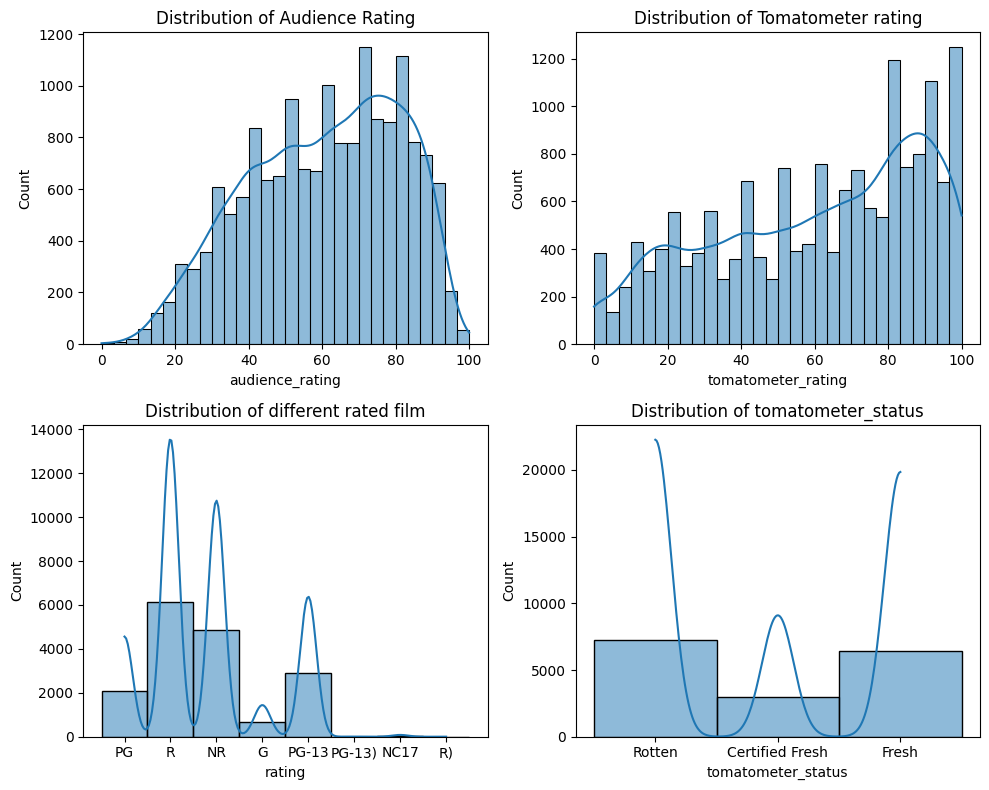

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

if 'audience_rating' in df.columns:
    axs[0,0].set_title('Distribution of Audience Rating')
    sns.histplot(df.audience_rating, bins=30, kde=True, ax=axs[0,0])    
else:
    raise ValueError("The Target variable is not in the data")

if 'tomatometer_rating' in df.columns:
    axs[0,1].set_title('Distribution of Tomatometer rating')
    sns.histplot(df.tomatometer_rating, bins=30, kde=True, ax=axs[0,1])    
else:
    raise ValueError("The Target variable is not in the data")

if 'rating' in df.columns:
    axs[1,0].set_title('Distribution of different rated film')
    sns.histplot(df.rating, bins=30, kde=True, ax=axs[1,0])    
else:
    raise ValueError("The Target variable is not in the data")

if 'tomatometer_status' in df.columns:
    axs[1,1].set_title('Distribution of tomatometer_status')
    sns.histplot(df.tomatometer_status, bins=30, kde=True, ax=axs[1,1])    
else:
    raise ValueError("The Target variable is not in the data")

plt.tight_layout()
plt.show()



In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

df = df.dropna()
date_col=df.select_dtypes(include=['datetime64[ns]']).columns

for col in date_col:
    df[col]=df[col].astype(np.int64)


encoded_variables={}
category_col=df.select_dtypes(include=['object']).columns

for col in category_col:
    if df[col].apply(type).nunique() >1:
        df[col]=df[col].astype(str)

    df[col]=le.fit_transform(df[col])
    encoded_variables[col] = le

X = df.drop(columns=['audience_rating'])
y = df['audience_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

models={"Linear Regression": LinearRegression(),
"Decision Tree": DecisionTreeRegressor(random_state=42),
"Random forest": RandomForestRegressor(n_estimators=100, random_state=42),
"Support vector machine": SVR(kernel='rbf'),
"XGboost":xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)}

Eval_results={}

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2  = r2_score(y_test, y_pred)

        Eval_results[name] = {'MAE':mae, 'MSE':mse, 'R2 SCORE': r2}

        print(f"{name} Performance:")
        print(f" MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}\n")

    except Exception as e:
         print(f"Error with model {name}: {e}")


result_df =pd.DataFrame(Eval_results)
print('Summary:')
result_df

Linear Regression Performance:
 MAE: 11.6641, MSE: 233.1652, R2 Score: 0.4374

Decision Tree Performance:
 MAE: 15.2384, MSE: 389.5039, R2 Score: 0.0601

Random forest Performance:
 MAE: 10.9275, MSE: 194.8625, R2 Score: 0.5298

Support vector machine Performance:
 MAE: 16.5475, MSE: 397.3103, R2 Score: 0.0413

XGboost Performance:
 MAE: 10.5234, MSE: 183.5240, R2 Score: 0.5571

Summary:


,Linear Regression,Decision Tree,Random forest,Support vector machine,XGboost
MAE,11.664087,15.238351,10.927496,16.547495,10.523423
MSE,233.165191,389.503883,194.862516,397.310260,183.524016
R2 SCORE,0.437351,0.060092,0.529779,0.041255,0.557140


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
        "n_estimators": [100, 200],  
        "learning_rate": [0.01, 0.05, 0.1], 
        "max_depth": [3, 6],  
    }

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters for XGBoost:", grid_search.best_params_)

Best Hyperparameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


In [22]:
best_rf = grid_search.best_estimator_
y_pred_final = best_rf.predict(X_test)
print("Final Model Performance:")
print("\n\tMAE:", mean_absolute_error(y_test, y_pred_final))
print("\tMSE:", mean_squared_error(y_test, y_pred_final))
print("\tR2 Score:", r2_score(y_test, y_pred_final))

Final Model Performance:

	MAE: 10.53204354379304
	MSE: 183.6858466917084
	R2 Score: 0.5567495305244201


In [23]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(**grid_search.best_params_, random_state=42))
])

pipeline.fit(X_train, y_train)
final_predictions = pipeline.predict(X_test)
print("Pipeline R2 Score:", r2_score(y_test, final_predictions))

pipeline_filename = 'audience_rating_pipeline.pkl'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline saved as {pipeline_filename}")


Pipeline R2 Score: 0.5567495305244201
Pipeline saved as audience_rating_pipeline.pkl


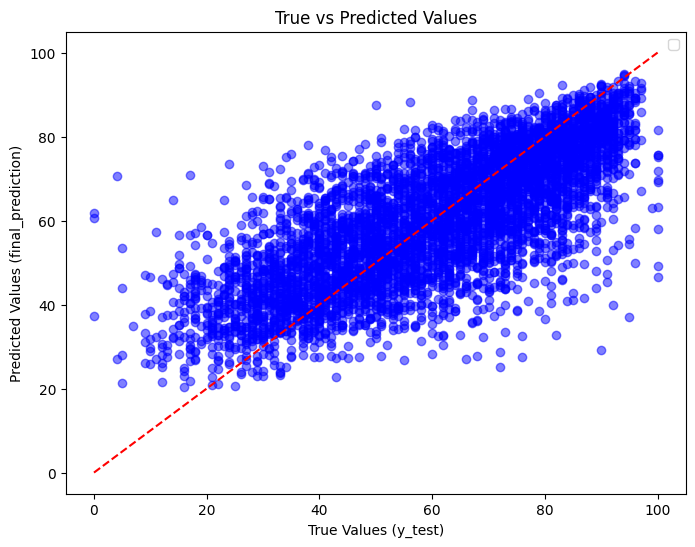

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, color='blue', alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (final_prediction)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.legend()
plt.show()

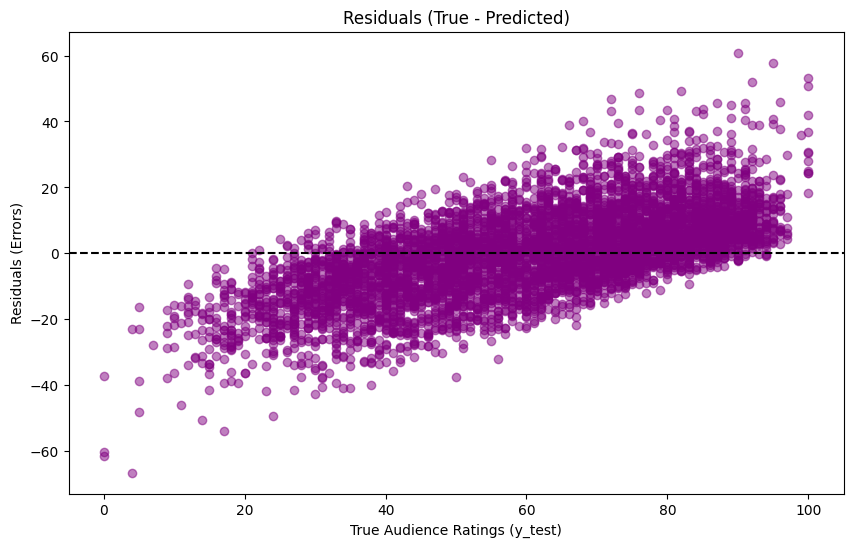

In [33]:
residuals = np.array(y_test) - np.array(final_predictions)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='purple', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (True - Predicted)')
plt.xlabel('True Audience Ratings (y_test)')
plt.ylabel('Residuals (Errors)')
plt.show()
